# SPARK Dataset


## Imports

In [24]:
from spark_utils import PyTorchSparkDataset, SPARKDataset
from matplotlib import pyplot as plt
from random import randint

In [25]:
import torch
import torchvision
from torchvision.transforms import v2 as T
from torchvision.transforms.v2 import functional as F
from torchvision import tv_tensors
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from engine import train_one_epoch, evaluate

# We are using BETA APIs, so we deactivate the associated warning, thereby acknowledging that
# some APIs may slightly change in the future
torchvision.disable_beta_transforms_warning()

## Defining the Dataset

By default, the output structure of the dataset is not compatible with the models or the transforms (https://pytorch.org/vision/master/transforms.html#v1-or-v2-which-one-should-i-use). To overcome that, we wrap a `PyTorchSparkDataset` in`PyTorchSparkDatasetV2`.

In the code below, we are wrapping images and bounding boxes `torchvision.TVTensor classes` so that we will be able to apply torchvision built-in transformations for the given object detection and segmentation task. Namely, image tensors will be wrapped by `torchvision.tv_tensors.Image` and bounding boxes into `torchvision.tv_tensors.BoundingBoxes`. Our dataset now returns a target which is dict where the values are `TVTensors` (all are `torch.Tensor` subclasses).

We also make the dataset compliant with COCO requirements so that it will work for both training and evaluation codes from the COCO reference script.

In [26]:
# Wrap a PyTorchSparkDataset dataset for usage with torchvision.transforms.v2
class PyTorchSparkDatasetV2(torch.utils.data.Dataset):
    def __init__(
        self,
        class_map,
        split="train",
        root_dir="./data/",
        transforms=None,
        sample_size=1,
    ):
        self.dataset = PyTorchSparkDataset(
            class_map, split=split, root_dir=root_dir, sample_size=sample_size
        )
        self.transforms = transforms
        self.split = split

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if self.split == "test":
            img, img_name = self.dataset[idx]
            img = tv_tensors.Image(img)
            return img, img_name
            
        else:
            img, label, bbox = self.dataset[idx]
    
            img = tv_tensors.Image(img)
    
            bbox = tv_tensors.BoundingBoxes(
                bbox, format=tv_tensors.BoundingBoxFormat.XYXY, canvas_size=F.get_size(img)
            )
            label = torch.tensor([label])
            area = (bbox[:, 3] - bbox[:, 1]) * (bbox[:, 2] - bbox[:, 0])
            iscrowd = torch.zeros((1,), dtype=torch.int64)
            image_id = idx
    
            target = {
                "boxes": bbox,
                "labels": label,
                "area": area,
                "iscrowd": iscrowd,
                "image_id": image_id,
            }
    
            if self.transforms is not None:
                img, target = self.transforms(img, target)
    
            return img, target

## Transforms

Let’s now define our pre-processing transforms. All the transforms know how to handle images, bouding boxes and masks when relevant.

Transforms are typically passed as the transforms parameter of the dataset so that they can leverage multi-processing from the `torch.utils.data.DataLoader`.

If the data is intended for training, a series of augmentation techniques are used. These include `RandomPhotometricDistort` to apply random color distortions (this helps the model generalize better across varying lighting conditions), and `RandomZoomOut` which randomly zooms out of the image (creating new perspectives and scales for the model to learn from).

The `RandomIoUCrop` performs a random crop based on the intersection-over-union (IoU) of the bounding boxes, and `RandomHorizontalFlip` and `RandomVerticalFlip` randomly flips the image horizontally and vertically (increasing the diversity of orientations). The `SanitizeBoundingBoxes` function adjusts and sanitizes the bounding boxes after these transformations are applied.

- http://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_e2e.html#transforms-v2-end-to-end-object-detection-segmentation-example
- https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py

In [32]:
# Define the transforms to be applied to the data.
def get_transform(split):
    transforms = []
    transforms.append(T.ToImage())

    if split == "train":
        transforms.append(T.RandomPhotometricDistort(p=0.5))
        transforms.append(
            T.RandomZoomOut(fill={tv_tensors.Image: (123, 117, 104), "others": 0})
        )
        transforms.append(T.RandomIoUCrop())
        transforms.append(T.RandomHorizontalFlip(p=0.5))
        transforms.append(T.RandomVerticalFlip(p=0.5))
        transforms.append(T.Resize((64, 64)))  # Remove this line
        transforms.append(T.SanitizeBoundingBoxes())

    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())

    return T.Compose(transforms)

## Loading Datasets

In [33]:
def get_dataset(split, class_map, data_path, sample_size=1):
    # We use the PyTorchSparkDatasetV2 class defined above.
    dataset = PyTorchSparkDatasetV2(
        class_map=class_map,
        split=split,
        root_dir=data_path,
        transforms=get_transform(split),
        sample_size=sample_size,
    )
    return dataset

In [35]:
# Set up the path to a local copy of the SPARK dataset, labels csv files should be in the same directory.
# The image sets should be in /data/train, /data/validation and /data/test.
data_path = "./data/"

# Define the class map, this is a dictionary that maps the class names to integer labels.
class_map = {
    "proba_2": 0,
    "cheops": 1,
    "debris": 2,
    "double_star": 3,
    "earth_observation_sat_1": 4,
    "lisa_pathfinder": 5,
    "proba_3_csc": 6,
    "proba_3_ocs": 7,
    "smart_1": 8,
    "soho": 9,
    "xmm_newton": 10,
}

# Define the number of classes
num_classes = len(class_map)

# # Define the datasets for training validation and testing
dataset = get_dataset(
    split="train", class_map=class_map, data_path=data_path, sample_size=0.01
)
dataset_valid = get_dataset(
    split="validation", class_map=class_map, data_path=data_path, sample_size=0.01
)
dataset_test = get_dataset(
    split="test", class_map=class_map, data_path=data_path
)

print(f"Number of training samples: {len(dataset)}")
print(f"Number of validation samples: {len(dataset_valid)}\n")
print(f"Number of test samples: {len(dataset_test)}\n")

Number of training samples: 660
Number of validation samples: 220

Number of test samples: 22000



In [36]:
# Check dataset format for debugging purposes
sample = dataset[0]
image, target = sample

print(f"Image type: {type(image)}")
print(f"Image shape: {image.shape}")
print(f"Image dtype: {image.dtype}")
print()
print(f"Target type: {type(target)}")
print("Target keys: ", list(target.keys()))
print()
print(f"Boxes type: {type(target['boxes'])}")
print(f"Boxes shape: {target['boxes'].shape}")
print()
print(f"Labels type: {type(target['labels'])}")
print(f"Labels shape: {target['labels'].shape}")
print(f"Labels dtype: {target['labels'].dtype}")

Image type: <class 'torch.Tensor'>
Image shape: torch.Size([3, 64, 64])
Image dtype: torch.float32

Target type: <class 'dict'>
Target keys:  ['boxes', 'labels', 'area', 'iscrowd', 'image_id']

Boxes type: <class 'torch.Tensor'>
Boxes shape: torch.Size([1, 4])

Labels type: <class 'torch.Tensor'>
Labels shape: torch.Size([1])
Labels dtype: torch.int64


/mnt/irisgpfs/users/dgareev/compvision_env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


## Visualizing Images

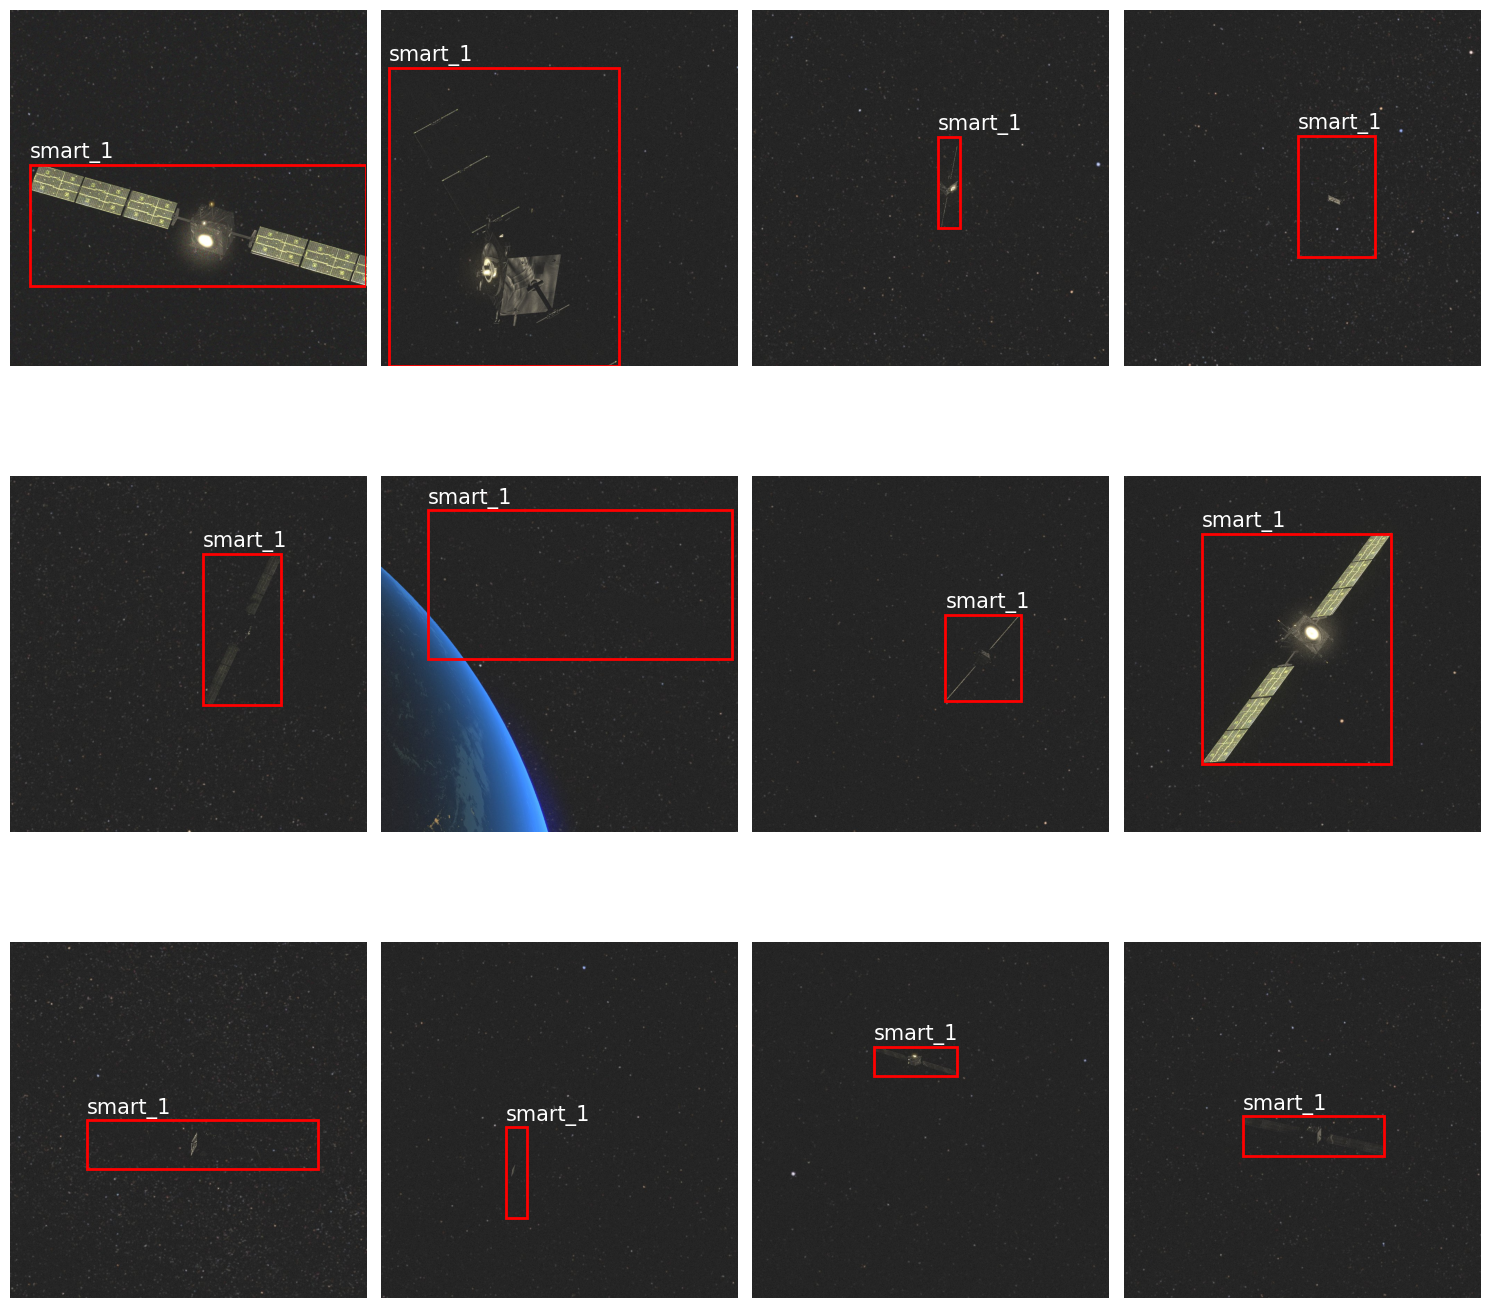

In [37]:
rows, cols = 3, 4
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

# Note that we are using the SPARKDataset class here instead of the PyTorchSparkDatasetV2 class
ds = SPARKDataset(class_map, root_dir=data_path, split="train")

for i in range(rows):
    for j in range(cols):
        ds.visualize(randint(0, len(dataset)), size=(10, 10), ax=axes[i][j])
        axes[i][j].axis("off")

fig.tight_layout()

## Define Dataloaders

In [38]:
# Define the batch size to be used.
batch_size = 2

# Define the dataloaders for training, validation and testing.
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=lambda batch: tuple(zip(*batch)),
)

data_loader_valid = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=lambda batch: tuple(zip(*batch)),
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=lambda batch: tuple(zip(*batch)),
)

## Defining Model

We will be using Faster R-CNN V2. Faster R-CNN V2 is a model that predicts both bounding boxes and class scores for potential objects in the image. It works similarly to Faster R-CNN with ResNet-50 FPN backbone.

We will start from a model pre-trained on COCO and finetune it for our particular classes in order to perform transfer learning.

- https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn_v2.html
- https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html
- https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [40]:
# Define the model
def get_model_instance_segmentation(num_classes):
    # Load an instance segmentation model pre-trained on COCO
    # TODO: Experiment with other weights such as 'COCO_V1'
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

## Model Training

Below is the main function which performs the training and the validation.

In [ ]:
# Train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# Move model to the right device
model.to(device)

# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# And a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Let's train it for 5 epochs
num_epochs = 1

for epoch in range(num_epochs):
    # Train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    # Update the learning rate
    lr_scheduler.step()
    # Evaluate on the test dataset
    evaluate(model, data_loader_valid, device=device)

/mnt/irisgpfs/users/dgareev/compvision_env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: [0]  [  0/330]  eta: 0:16:10  lr: 0.000020  loss: 2.4647 (2.4647)  loss_classifier: 2.3258 (2.3258)  loss_box_reg: 0.0282 (0.0282)  loss_objectness: 0.0972 (0.0972)  loss_rpn_box_reg: 0.0135 (0.0135)  time: 2.9422  data: 0.1246  max mem: 3687
Epoch: [0]  [100/330]  eta: 0:01:29  lr: 0.001538  loss: 0.3043 (0.6075)  loss_classifier: 0.1528 (0.4539)  loss_box_reg: 0.1066 (0.0701)  loss_objectness: 0.0267 (0.0742)  loss_rpn_box_reg: 0.0036 (0.0093)  time: 0.3656  data: 0.1646  max mem: 3851
Epoch: [0]  [200/330]  eta: 0:00:48  lr: 0.003057  loss: 0.2533 (0.4312)  loss_classifier: 0.1133 (0.2872)  loss_box_reg: 0.0859 (0.0786)  loss_objectness: 0.0245 (0.0572)  loss_rpn_box_reg: 0.0049 (0.0083)  time: 0.3608  data: 0.1590  max mem: 3851
Epoch: [0]  [300/330]  eta: 0:00:11  lr: 0.004575  loss: 0.2455 (0.3688)  loss_classifier: 0.1166 (0.2275)  loss_box_reg: 0.0878 (0.0803)  loss_objectness: 0.0206 (0.0526)  loss_rpn_box_reg: 0.0043 (0.0083)  time: 0.3756  data: 0.1775  max mem: 3851


## Compute Predictions

In [ ]:
# Switch the model to evaluation mode
model.eval()

In [10]:
len(data_loader_test)

0

In [ ]:
# Open the csv file
with open("predictions.csv", "w") as f:
    f.write("filename,class,bbox\n")
    # Loop over the test dataset
    for i, (images, targets) in enumerate(data_loader_test):
        # Move the images to the device
        images = list(image.to(device) for image in images)
        # Compute the model predictions
        with torch.no_grad():
            predictions = model(images)
        # Loop over the predictions
        for prediction in predictions:
            print(prediction)
            # Get the predicted boxes, labels and scores
            boxes = prediction["boxes"].cpu().numpy()
            labels = prediction["labels"].cpu().numpy()
            scores = prediction["scores"].cpu().numpy()
            # Write the predictions to the csv file
            for box, label in zip(boxes, labels):
                # Convert the bounding box coordinates to integers
                box = list(map(int, box))
                f.write(f"{dataset_test.imgs[i]},{label},{box}\n")